In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from torch.utils.data import TensorDataset,DataLoader, random_split
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
fnexpr='exprLOW.csv'
fnmet='methylLOW.csv'
fnassig='assignLOW.csv'
nsamp=10000
fnmodel='MTETRANSF2-10K.pth'


#Función para contar número de parámetros del modelo
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
# Definir el modelo Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, nhead, nhid, nlayers, decoder_layers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.tgt_mask = None

        self.encoder = nn.Linear(input_dim, nhid)
        self.transformer_encoder = TransformerEncoder(TransformerEncoderLayer(nhid, nhead, nhid, dropout), nlayers)

        self.decoder_input = nn.Linear(output_dim, nhid)
        self.transformer_decoder = TransformerDecoder(TransformerDecoderLayer(nhid, nhead, nhid, dropout), decoder_layers)
        self.output_layer = nn.Linear(nhid, output_dim)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        src = self.encoder(src)
        memory = self.transformer_encoder(src, src_mask)

        tgt = self.decoder_input(tgt)
        output = self.transformer_decoder(tgt, memory, tgt_mask)
        output = self.output_layer(output)
        return output
        
# Leer datos
expression_data = pd.read_csv(fnexpr)
methylation_data = pd.read_csv(fnmet)
assign_data = pd.read_csv(fnassig)

expression_data = expression_data.iloc[:, 1:]
methylation_data = methylation_data.iloc[:, 1:]
assign_data = assign_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
methylation_data = methylation_data.apply(pd.to_numeric, errors='coerce')
assign_data = assign_data.apply(pd.to_numeric, errors='coerce')

# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
#expression_data.fillna(0, inplace=True)
#methylation_data.fillna(0, inplace=True)
#assign_data.fillna(0, inplace=True)

#Normalizamos
scaler = MinMaxScaler()

expression_data_scaled = scaler.fit_transform(expression_data)
methylation_data_scaled = scaler.fit_transform(methylation_data)
assign_data_scaled =assign_data

# Convertir a DataFrame
expression_data = pd.DataFrame(expression_data_scaled, index=expression_data.index, columns=expression_data.columns)
methylation_data = pd.DataFrame(methylation_data_scaled, index=methylation_data.index, columns=methylation_data.columns)
assign_data = pd.DataFrame(assign_data_scaled, index=assign_data.index, columns=assign_data.columns)

#print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"

expression_data_tensor = torch.FloatTensor(expression_data.values).to(device)
methylation_data_tensor = torch.FloatTensor(methylation_data.values).to(device)
assign_data_tensor = torch.FloatTensor(assign_data.values).to(device)

# Dividir en conjuntos de entrenamiento y prueba
dataset = TensorDataset(expression_data_tensor, methylation_data_tensor)
train_size = int(0.9 * len(dataset))  # Ajusta esto según tu necesidad
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Convertir los Subset en tensores para el entrenamiento
expression_train, methylation_train= zip(*[(e, m) for e, m in train_dataset])
expression_train = torch.stack(expression_train)
methylation_train = torch.stack(methylation_train)
#assign_train = torch.stack(assign_train)

# Convertir los Subset en tensores para la validación/prueba
expression_test, methylation_test = zip(*[(e, m) for e, m in test_dataset])
expression_test = torch.stack(expression_test)
methylation_test = torch.stack(methylation_test)
#assign_test = torch.stack(assign_test)
input_dim = methylation_data.shape[1]
output_dim = expression_data.shape[1]
# Parámetros del Transformer

nhead = 8  # Número de cabezas en el multiheadattention
nhid = 2048  # Dimensión oculta
nlayers = 4  # Número de capas TransformerEncoderLayer
dropout = 0.2  # Probabilidad de dropout
# Entrenamiento
def generate_square_subsequent_mask(sz):
    mask = torch.triu(torch.ones(sz, sz), 1)
    mask = mask.masked_fill(mask == 1, float('-inf'))
    return mask


In [2]:

# Crear instancia del modelo
model = TransformerModel(input_dim, output_dim, nhead, nhid, nlayers,nlayers, dropout).to(device)

# Hiperparámetros y optimizador
lr = 0.00002  # Tasa de aprendizaje
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()



def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for batch in data_loader:
        expression_data, methylation_data = batch
        expression_data = expression_data.to(device)
        methylation_data = methylation_data.to(device)

        optimizer.zero_grad()

        src_mask = generate_square_subsequent_mask(methylation_data.size(0)).to(device)
        tgt_mask = generate_square_subsequent_mask(expression_data.size(0)).to(device)

        # Asumiendo que methylation_data es el target
        output = model(methylation_data, expression_data, src_mask, tgt_mask)
        loss = criterion(output, expression_data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

# Configuración del entrenamiento
n_epochs = 100  # Número de épocas
best_val_loss = float('inf')


# Crear DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Bucle de entrenamiento
for epoch in range(n_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')

    # Guardar el modelo si es el mejor hasta ahora
    if train_loss < best_val_loss:
        best_val_loss = train_loss
        torch.save(model.state_dict(), fnmodel)
        print(f"Saved model with Train Loss: {train_loss:.6f}")




/home/fede/PyEnv/PB/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB. GPU 0 has a total capacty of 7.58 GiB of which 38.88 MiB is free. Including non-PyTorch memory, this process has 7.52 GiB memory in use. Of the allocated memory 7.33 GiB is allocated by PyTorch, and 14.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

True


/home/fede/PyEnv/PB/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


tensor([[0.0152, 0.0765, 0.5401,  ..., 0.1246, 0.0776, 0.1172],
        [0.0218, 0.1204, 0.3552,  ..., 0.0939, 0.2186, 0.2847],
        [0.0364, 0.1264, 0.6233,  ..., 0.2015, 0.1266, 0.1535],
        ...,
        [0.0333, 0.0889, 0.3173,  ..., 0.2276, 0.0432, 0.1019],
        [0.0571, 0.1744, 0.4513,  ..., 0.3375, 0.1585, 0.3247],
        [0.0298, 0.1173, 0.8756,  ..., 0.1539, 0.1858, 0.2015]],
       device='cuda:0')
[[0.13631503 0.64666504 0.8565654  ... 0.35032776 0.45750913 0.43699443]
 [0.24054398 0.15384746 0.7298739  ... 0.3393546  0.6963503  0.5320857 ]
 [0.29100153 0.64074224 0.7377509  ... 0.37236813 0.5183043  0.45558754]
 ...
 [0.23401253 0.75447255 0.7781781  ... 0.5150029  0.5227867  0.5045115 ]
 [0.16766642 0.62967753 0.8814825  ... 0.54818195 0.49560887 0.5262444 ]
 [0.19795537 0.3851839  0.656601   ... 0.47806877 0.7511634  0.3742732 ]]
[[ 0.23587877  0.16269498  0.22881378 ...  0.17308481 -0.04183552
   0.06337504]
 [ 0.23587877  0.16269498  0.22881378 ...  0.17308481

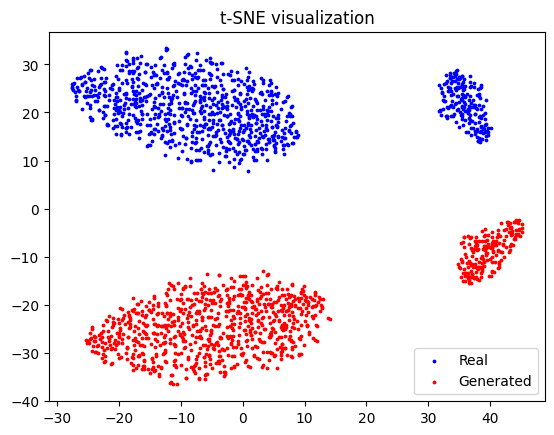

/home/fede/PyEnv/PB/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


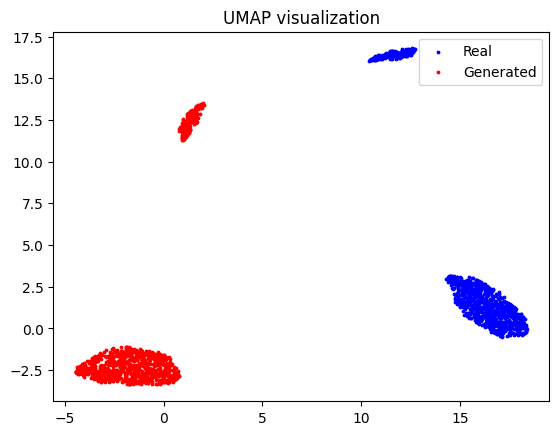

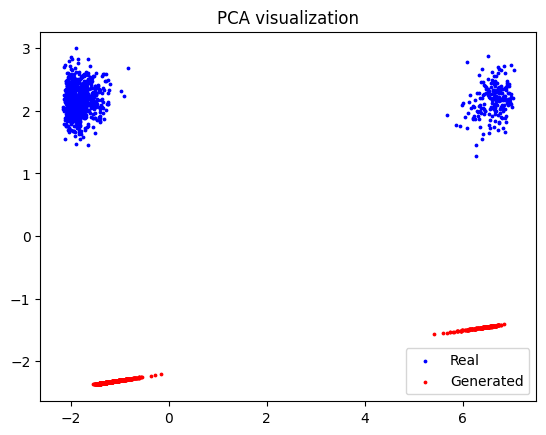

In [5]:
import torch
import pandas as pd
from sklearn.metrics import mean_squared_error
from torch.nn.functional import mse_loss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy.stats import wasserstein_distance, ks_2samp
import sys
import umap
from scipy.stats import pearsonr
from math import sqrt

# Convertir los tensores a numpy y luego a DataFrame de pandas
expression_data_test_np = expression_test.cpu().numpy()
methylation_data_test_np = methylation_test.cpu().numpy()

expression_data_test_df = pd.DataFrame(expression_data_test_np)
methylation_data_test_df = pd.DataFrame(methylation_data_test_np)

X_real = pd.concat([expression_data_test_df, methylation_data_test_df], axis=1)

print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"

# Cargar el modelo Transformer previamente entrenado
model = TransformerModel(input_dim, output_dim, nhead, nhid, nlayers,nlayers, dropout).to(device)  # Asegúrate de proporcionar los parámetros correctos aquí
model.load_state_dict(torch.load(fnmodel))
model.eval()
model.to(device)


# Generar datos de metilación utilizando el modelo Transformer
src_mask = generate_square_subsequent_mask(methylation_test.size(0)).to(device)

# Los datos objetivo (tgt) para la predicción pueden ser inicializados como ceros
# Esto es un estándar en algunas implementaciones de modelos de secuencia a secuencia
expression_pred = torch.zeros_like(expression_test).to(device)

# Realizar la predicción
with torch.no_grad():
    generated_expr = model(methylation_test, expression_pred, None, None)



# Convertir los datos generados a formato numpy
generated_expr = generated_expr.cpu().numpy()

generated_expr_data = generated_expr[:, :expression_test.shape[1]]

# Convertir a DataFrame de pandas
generated_expr_data_df = pd.DataFrame(generated_expr_data)

X_gan = pd.concat([generated_expr_data_df,methylation_data_test_df ], axis=1)

X_gan.columns = X_real.columns

# Concatena los datos reales con los generados
X_combined = np.vstack([X_real, X_gan])
print(methylation_test)
print(expression_data_test_np)
print(generated_expr_data)
# Calcular el MSE
mse = mean_squared_error(expression_data_test_np, generated_expr_data)

print(f"MSE entre los datos de metilación reales y los generados: {mse}")
rmse = sqrt(mse)
print(f"RMSE: {rmse}")
pcc, _ = pearsonr(expression_data_test_np.flatten(), generated_expr_data.flatten())
print(f"PCC: {pcc}")

#t-SNE
labels = np.concatenate([np.ones(X_real.shape[0]), np.zeros(X_gan.shape[0])])
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined)

plt.scatter(X_tsne[labels==1, 0], X_tsne[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_tsne[labels==0, 0], X_tsne[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('t-SNE visualization')
#plt.savefig(filename+"tsne.jpg")
plt.show()

# Configurando y entrenando UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_combined)

# Dibujando la visualización
plt.scatter(X_umap[labels==1, 0], X_umap[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_umap[labels==0, 0], X_umap[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('UMAP visualization')
#plt.savefig(filename+"umap.jpg")
plt.show()


#PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

plt.scatter(X_pca[labels==1, 0], X_pca[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_pca[labels==0, 0], X_pca[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('PCA visualization')
#plt.savefig(filename+"pca.jpg")
plt.show()